In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
import torch.nn as nn
from tqdm.notebook import tqdm, trange
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import pandas as pd
import torch.nn.functional as F
import matplotlib.pyplot as plt
import zipfile
from google.colab import drive
import os
import numpy as np
import warnings
from torchvision import transforms
from torchsummary import summary
from torchvision.io import read_image
import time
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import torchvision.models as models
import torch.optim as optim

warnings.filterwarnings('ignore')

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
zip_file_path = '/content/drive/MyDrive/ROP_datasets/annotations.zip'
# Распаковать архив в текущую папку
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall()

In [ ]:
class ROP_Dataset(Dataset):
    def __init__(self, txt_file, image_dir, transform=None):
        self.image_list = pd.read_csv(txt_file, header=None)
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_list.iloc[idx, 0])
        image = Image.open(img_path)
        img_tag = self.image_list.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)
        sample = {"image": image, "tag": img_tag}

        return image, img_tag

In [ ]:
MEAN = torch.tensor([0.485, 0.456, 0.406])
STD  = torch.tensor([0.229, 0.224, 0.225])

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)  # Normaliztion
])

# Create Dataset Training
dataset_train = ROP_Dataset(txt_file='./annotations/train.txt', image_dir='./annotations/images', transform=transform)
# Create Dataset Testing
dataset_test = ROP_Dataset(txt_file='./annotations/test.txt', image_dir='./annotations/images', transform=transform)
# Create Dataset Validation
dataset_valid = ROP_Dataset(txt_file='./annotations/valid.txt', image_dir='./annotations/images', transform=transform)

# DataLoader Training
dataloader_train = DataLoader(dataset_train, batch_size=32, shuffle=True)
# DataLoader Testing
dataloader_test = DataLoader(dataset_test, batch_size=32, shuffle=True)
# DataLoader Validation
dataloader_valid = DataLoader(dataset_valid, batch_size=32, shuffle=True)

In [ ]:
print(f'Number of training examples: {len(dataset_train)}')
print(f'Number of validation examples: {len(dataset_valid)}')
print(f'Number of test examples: {len(dataset_test)}')

Number of training examples: 481
Number of validation examples: 70
Number of test examples: 137


In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Using {device} for inference')

Using cuda for inference


In [ ]:
model = models.efficientnet_b0(weights='IMAGENET1K_V1', progress=True).to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 76.6MB/s]


In [ ]:
params = list(model.named_parameters())

# print(params)
for idx in range(len(params)):
    print(params[idx][0],'\t', params[idx][1].size())
print('\n',10*'--')
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Number of trainable parameters for the model: %d' % (num_params))

num_params = sum(p.numel() for p in model.parameters() )
print('Number of all parameters for the model: %d' % (num_params))

features.0.0.weight 	 torch.Size([32, 3, 3, 3])
features.0.1.weight 	 torch.Size([32])
features.0.1.bias 	 torch.Size([32])
features.1.0.block.0.0.weight 	 torch.Size([32, 1, 3, 3])
features.1.0.block.0.1.weight 	 torch.Size([32])
features.1.0.block.0.1.bias 	 torch.Size([32])
features.1.0.block.1.fc1.weight 	 torch.Size([8, 32, 1, 1])
features.1.0.block.1.fc1.bias 	 torch.Size([8])
features.1.0.block.1.fc2.weight 	 torch.Size([32, 8, 1, 1])
features.1.0.block.1.fc2.bias 	 torch.Size([32])
features.1.0.block.2.0.weight 	 torch.Size([16, 32, 1, 1])
features.1.0.block.2.1.weight 	 torch.Size([16])
features.1.0.block.2.1.bias 	 torch.Size([16])
features.2.0.block.0.0.weight 	 torch.Size([96, 16, 1, 1])
features.2.0.block.0.1.weight 	 torch.Size([96])
features.2.0.block.0.1.bias 	 torch.Size([96])
features.2.0.block.1.0.weight 	 torch.Size([96, 1, 3, 3])
features.2.0.block.1.1.weight 	 torch.Size([96])
features.2.0.block.1.1.bias 	 torch.Size([96])
features.2.0.block.2.fc1.weight 	 torch.S

In [ ]:
# Функция для смены полносвяного слоя
def change_num_classes(n, model):
    n_classes = n
    n_fc_in = model.classifier[1].in_features

    model.classifier[1] = nn.Linear(n_fc_in, n_classes).to(device)

    nn.init.xavier_uniform_(model.classifier[1].weight)
    model.classifier[1].bias.data.fill_(0)

In [ ]:
# Загрузка функции потерь
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)

In [ ]:
# Функция запуска обучения и проверка на тестовой выборке
def run_model(learningRate, num_epochs):
    # Define Adam optimizer with the current learning rate
    optimizer = optim.SGD(model.parameters(), lr=learningRate)

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        all_labels = []
        all_predictions = []
        for inputs, labels in dataloader_train:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

        # Calculate average training loss per epoch
        epoch_loss = running_loss / len(dataset_train)
        precision = precision_score(all_labels, all_predictions, average='weighted')
        recall = recall_score(all_labels, all_predictions, average='weighted')
        accuracy = accuracy_score(all_labels, all_predictions)
        print(f"Training - Learning Rate: {learningRate} - Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}, Recall: {recall:.4f}, Precision: {precision:.4f}, Accuracy: {accuracy:.4f}")

    # Evaluation loop
    model.eval()
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for inputs, labels in dataloader_valid:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)

            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    precision = precision_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')
    accuracy = accuracy_score(all_labels, all_predictions)
    print(f"\n\nValidation - Learning Rate: {learningRate}, Recall: {recall:.4f}, Precision: {precision:.4f}, Accuracy: {accuracy:.4f}\n\n")

    # Testing loop
    # Set model to evaluation mode
    model.eval()

    # Lists to store true labels and predicted labels
    all_labels = []
    all_predictions = []

    # Loop through the test dataset
    with torch.no_grad():
        for inputs, labels in dataloader_test:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)

            # Get predicted labels
            _, predicted = torch.max(outputs, 1)

            # Append true labels and predicted labels
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    # Calculate precision, recall, and accuracy
    precision = precision_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')
    accuracy = accuracy_score(all_labels, all_predictions)

    print(f"\n\nTesting - Learning Rate: {learningRate}, Recall: {recall:.4f}, Precision: {precision:.4f}, Accuracy: {accuracy:.4f}\n\n")

In [ ]:
# Define learning rates
learning_rates = [0.001, 0.005, 0.01, 0.02, 0.03, 0.05, 0.08]

In [ ]:
# Для поиска наилучшего lr
num_epochs = 30

for lr in learning_rates:
    model = models.efficientnet_b0(weights='IMAGENET1K_V1', progress=True).to(device)
    change_num_classes(3, model)
    run_model(lr, num_epochs)

NameError: name 'learning_rates' is not defined

In [ ]:
num_epochs = 35
change_num_classes(2, model)
run_model(0.01, num_epochs)

Training - Learning Rate: 0.01 - Epoch 1/35, Training Loss: 0.5517, Recall: 0.7588, Precision: 0.7934, Accuracy: 0.7588
Training - Learning Rate: 0.01 - Epoch 2/35, Training Loss: 0.3294, Recall: 0.9189, Precision: 0.9110, Accuracy: 0.9189
Training - Learning Rate: 0.01 - Epoch 3/35, Training Loss: 0.2304, Recall: 0.9293, Precision: 0.9346, Accuracy: 0.9293
Training - Learning Rate: 0.01 - Epoch 4/35, Training Loss: 0.1783, Recall: 0.9418, Precision: 0.9433, Accuracy: 0.9418
Training - Learning Rate: 0.01 - Epoch 5/35, Training Loss: 0.1521, Recall: 0.9543, Precision: 0.9565, Accuracy: 0.9543
Training - Learning Rate: 0.01 - Epoch 6/35, Training Loss: 0.1162, Recall: 0.9709, Precision: 0.9718, Accuracy: 0.9709
Training - Learning Rate: 0.01 - Epoch 7/35, Training Loss: 0.1030, Recall: 0.9730, Precision: 0.9731, Accuracy: 0.9730
Training - Learning Rate: 0.01 - Epoch 8/35, Training Loss: 0.1052, Recall: 0.9813, Precision: 0.9817, Accuracy: 0.9813
Training - Learning Rate: 0.01 - Epoch 9

In [26]:
n_classes = 2
n_samples = len(dataloader_test)
names_classes = ["healthy", "unhealthy"]
names_classes_3 = ["healthy", "stage 2-3", "plus"]

class_correct = torch.zeros(n_classes)
class_total   = torch.zeros(n_classes)

labels   = []
predicts = []

model.eval()

with torch.no_grad():

    for x,y in tqdm(dataloader_test):
        x = x.to(device)
        y = y.to('cpu')

        y_pred = model.forward(x).to('cpu')

        cls_pred = torch.argmax(y_pred, dim=1)

        c = (cls_pred == y).squeeze() # one-hot vector

        for i in range(x.shape[0]):
            label = y[i]
            class_correct[label] += c[i].item()
            class_total[label]   += 1

        labels.append(y)
        predicts.append(cls_pred)

labels   = torch.cat(labels, dim = 0) # make it 1d array
predicts = torch.cat(predicts, dim = 0) # make it 1d array

for i in range(n_classes):
    print('Accuracy of %5s : %2d %%' % (
        names_classes[i], 100 * class_correct[i] / class_total[i]))

  0%|          | 0/5 [00:00<?, ?it/s]

Accuracy of healthy : 100 %
Accuracy of unhealthy : 100 %


In [27]:
def plot_confusion_matrix(labels, pred_labels, names_classes):

    fig, ax = plt.subplots(figsize=(10, 10))

    cm = confusion_matrix(np.asarray(labels, dtype=int),
                          np.asarray(pred_labels, dtype=int) )

    cm = ConfusionMatrixDisplay(cm, display_labels=names_classes)

    cm.plot(values_format='d', cmap='coolwarm', ax=ax)
    fig.savefig('./cm.jpeg')

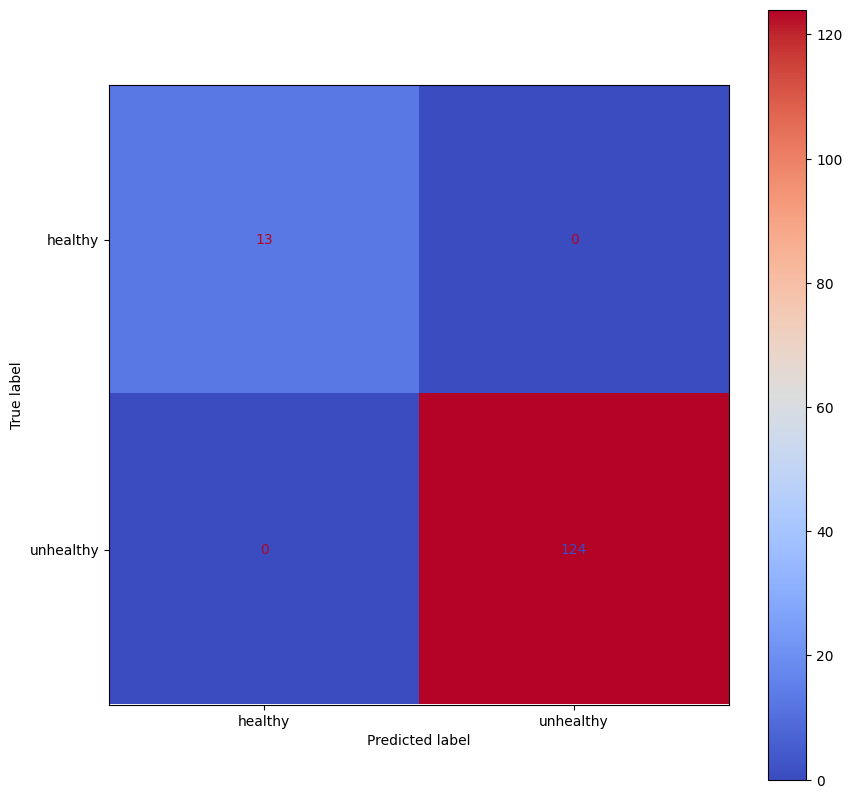

In [28]:
plot_confusion_matrix(labels.cpu(), predicts.cpu(), names_classes)